In [1]:
from PIL import Image
import cv2
import pandas as pd
import numpy as np
# import tensorflow_hub as hub
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

ModuleNotFoundError: No module named 'cv2'

In [2]:
X_train = np.load('flower_species_classification/data_train.npy').T
t_train = np.load('flower_species_classification/labels_train.npy')

X_test = np.load('flower_species_classification/data_test.npy').T
t_test = np.load('flower_species_classification/labels_test.npy')

print(X_train.shape, t_train.shape)

(1658, 270000) (1658,)


In [3]:
NEW_SIZE = (224,224)
INTERPOLATION = cv2.INTER_CUBIC
data = []

for i in range(1658):
    img = X_train[i,:].reshape(300,300,3)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = tf.image.convert_image_dtype(img, tf.float32)
    # img = tf.image.resize(img, NEW_SIZE)
    img = cv2.resize(img, NEW_SIZE, interpolation=INTERPOLATION)
    img = np.array(img)
    data.append(img)

X_train_resized = np.array(data)
X_train_resized.shape

(1658, 224, 224, 3)

In [4]:
#Splitting data into training and validation
X_training, X_val, t_training, t_val = train_test_split(X_train_resized, t_train, shuffle = True, test_size=0.3, random_state=28)

In [5]:
# model = MobileNet(input_shape=(224,224,3), include_top=True)
# base_model = hub.load("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4")
# base_model = keras.applications.MobileNet(
#     input_shape=(224,224,3),
#     alpha=1.0,
#     depth_multiplier=1,
#     dropout=0.001,
#     include_top=True,
#     weights="imagenet",
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
# )

base_model = keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(224, 224, 3)),
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

base_model.trainable = False

2023-12-06 22:44:39.526769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:47:00.0, compute capability: 8.0
2023-12-06 22:44:39.528561: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79087 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:4e:00.0, compute capability: 8.0


In [6]:
#Accuracy for 1 hidden layer = 55 %
#Accuracy for 2 hidden layers = 66 % 
#Accuracy for 3 hidden layers =  % but val_loss higher  indicating overfitting
#Accuracy for 4 hidden layer =  %

model = keras.models.Sequential([
    base_model,
    keras.layers.Flatten(), # another option is to use the Global Average Pooling if feature maps are at most 7x7
    keras.layers.Dense(64, activation='relu'), 
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'), 
    keras.layers.Dense(10, activation='softmax')
])

In [7]:
# Learning rate = 0.001 - Accuracy = 65%
#Learning rate = 0.03 - Overfitting
loss = keras.losses.SparseCategoricalCrossentropy()

optimizer = keras.optimizers.Adam(
    learning_rate=0.001,
    name="adam")

model.compile(optimizer= optimizer, loss=loss, metrics=['accuracy'])

In [8]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  monitor='val_loss',
                                                 restore_best_weights=True)


flowers = model.fit(X_training,t_training, epochs = 300,batch_size = 5, validation_data=(X_val, t_val), callbacks=[early_stopping_cb])

model.save("Models/Flowers.h5")

Epoch 1/300


2023-12-06 22:44:55.051299: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-06 22:44:57.186065: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1495b9c73310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-06 22:44:57.186111: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-12-06 22:44:57.186116: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-12-06 22:44:57.190505: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-06 22:44:57.279029: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


232/232 [==============================] - 6s 11ms/step - loss: 1.6780 - accuracy: 0.4362 - val_loss: 0.8935 - val_accuracy: 0.7349
Epoch 2/300
232/232 [==============================] - 2s 8ms/step - loss: 1.1244 - accuracy: 0.6500 - val_loss: 0.5862 - val_accuracy: 0.8273
Epoch 3/300
232/232 [==============================] - 2s 8ms/step - loss: 0.7499 - accuracy: 0.7603 - val_loss: 0.4977 - val_accuracy: 0.8574
Epoch 4/300
232/232 [==============================] - 2s 8ms/step - loss: 0.6255 - accuracy: 0.8078 - val_loss: 0.4111 - val_accuracy: 0.8735
Epoch 5/300
232/232 [==============================] - 2s 9ms/step - loss: 0.5152 - accuracy: 0.8353 - val_loss: 0.4054 - val_accuracy: 0.8735
Epoch 6/300
232/232 [==============================] - 2s 8ms/step - loss: 0.5446 - accuracy: 0.8233 - val_loss: 0.3746 - val_accuracy: 0.8755
Epoch 7/300
232/232 [==============================] - 2s 8ms/step - loss: 0.4264 - accuracy: 0.8560 - val_loss: 0.3963 - val_accuracy: 0.8655
Epoch 8/30

/apps/tensorflow/2.14/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 20ms/step
Classification Report for Training set:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       131
         1.0       1.00      1.00      1.00       129
         2.0       0.99      1.00      1.00       153
         3.0       1.00      1.00      1.00        97
         4.0       1.00      1.00      1.00       119
         5.0       1.00      1.00      1.00       100
         6.0       1.00      1.00      1.00       116
         7.0       1.00      1.00      1.00       119
         8.0       1.00      1.00      1.00       103
         9.0       1.00      0.99      0.99        93

    accuracy                           1.00      1160
   macro avg       1.00      1.00      1.00      1160
weighted avg       1.00      1.00      1.00      1160



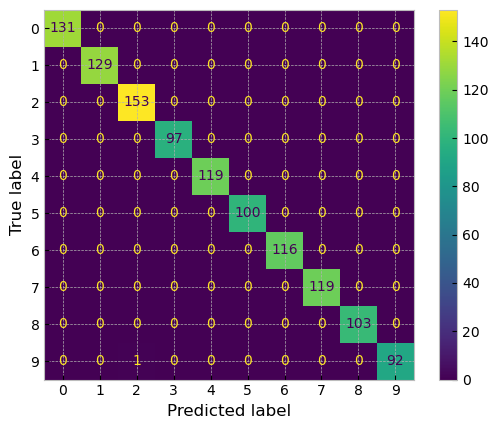

<Figure size 5000x1000 with 0 Axes>

Classification Report for Validation set:
               precision    recall  f1-score   support

         0.0       0.74      0.93      0.83        46
         1.0       0.96      0.90      0.93        51
         2.0       0.88      0.83      0.85        52
         3.0       1.00      0.95      0.98        43
         4.0       0.92      0.87      0.90        54
         5.0       0.98      0.95      0.96        56
         6.0       0.88      0.84      0.86        44
         7.0       0.84      0.96      0.89        53
         8.0       0.94      0.98      0.96        59
         9.0       0.91      0.72      0.81        40

    accuracy                           0.90       498
   macro avg       0.90      0.89      0.90       498
weighted avg       0.91      0.90      0.90       498



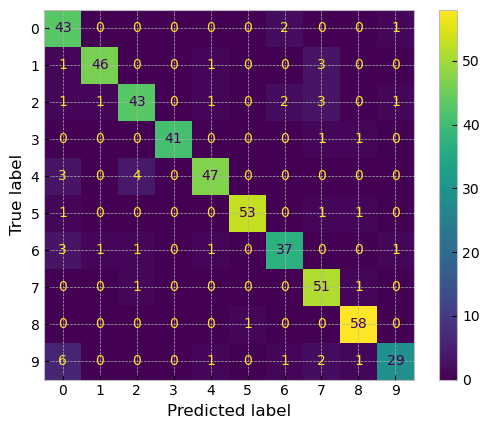

<Figure size 1000x700 with 0 Axes>

In [10]:
class_names = ['Roses', 'Magnolias', 'Lilies', 'Sunflowers', 'Orchids', 
               'Marigold', 'Hibiscus', 'Firebush', 'Pentas', 'Bougainvillea']

#Printing the training and validation scores
y_train = np.argmax(model.predict(X_training), axis = 1)
y_valid = np.argmax(model.predict(X_val), axis = 1)


print("Classification Report for Training set:\n", classification_report(t_training, y_train))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(t_training, y_train))
disp.plot()
plt.figure(figsize = (50,10))
plt.show()
# print(r2_score(t_val, y_valid))
print("Classification Report for Validation set:\n", classification_report(t_val, y_valid))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(t_val, y_valid))
disp.plot()
plt.figure(figsize = (10,7))
plt.show()

In [11]:
NEW_SIZE = (224,224)
INTERPOLATION = cv2.INTER_CUBIC
data = []

for i in range(415):
    img = X_test[i,:].reshape(300,300,3)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = tf.image.convert_image_dtype(img, tf.float32)
    # img = tf.image.resize(img, NEW_SIZE)
    img = cv2.resize(img, NEW_SIZE, interpolation=INTERPOLATION)
    img = np.array(img)
    data.append(img)

X_test_resized = np.array(data)

model.evaluate(X_test_resized, t_test)

13/13 [==============================] - 1s 82ms/step - loss: 0.6127 - accuracy: 0.8554


[0.612656831741333, 0.8554216623306274]

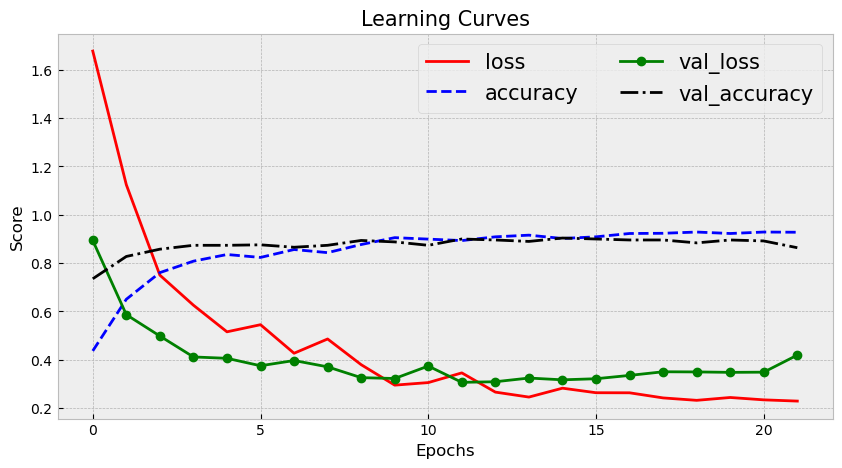

In [12]:
key_names = list(flowers.history.keys())
colors = ['-r','--b','-og','-.k']

plt.figure(figsize=(10,5))
for i in range(len(key_names)):
    plt.plot(flowers.history[key_names[i]], colors[i], label=key_names[i])
plt.legend(fontsize=15,ncol=2)
plt.title('Learning Curves', size=15);
plt.xlabel('Epochs');
plt.ylabel('Score');


### 2. Car detection

In [13]:
bbox = pd.read_csv('car_detection_dataset/train_bounding_boxes.csv')
bbox

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864


In [14]:
N = len(bbox) # no. of training samples

# Create a numpy array with all images
for i in range(N): 
    filename='car_detection_dataset/training_images/'+bbox['image'][i]
    image = np.array(Image.open(filename))
    image_col = image.ravel()[:,np.newaxis]
    (h, w) = image.shape[:2]
    
    if i==0:
        X_train = image_col
    else:
        X_train = np.hstack((X_train, image_col))

# Training feature matrices
X_train = X_train.T

# Training labels
t_train = bbox.drop('image', axis=1).round().to_numpy().astype(int)

t_train = t_train.astype(float)

t_train[:, [0, 2]] /= w
t_train[:, [1, 3]] /= h

X_train.shape, t_train.shape

((559, 770640), (559, 4))

In [15]:
# NEW_SIZE = (224,224)
# INTERPOLATION = cv2.INTER_CUBIC
data = []

for i in range(559):
    img = X_train[i,:].reshape(380,676,3)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = tf.image.convert_image_dtype(img, tf.float32)
    # img = tf.image.resize(img, NEW_SIZE)
    # img = cv2.resize(img, NEW_SIZE, interpolation=INTERPOLATION)
    img = np.array(img)
    data.append(img)

X_train_resized = np.array(data)
X_train_resized.shape

#Splitting data into training and validation
X_training, X_val, t_training, t_val = train_test_split(X_train_resized, t_train, shuffle = True, test_size=0.3, random_state=2)

In [16]:
base_model = keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    input_tensor=Input(shape=(380, 676, 3))
)

base_model.trainable = False

In [17]:
#Relu activation function was giving bad results, use sigmoid since I have normalized the t_train values between 0 and 1.
# The Relu activation function was giving 0 accuracy as it was having vanishing gradient problem, this was due to the fact that I did not use batch normalization.
model = keras.models.Sequential([
    base_model,
    keras.layers.Flatten(), 
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(4, activation='sigmoid') #without normalization
])

In [18]:
loss = keras.losses.MeanSquaredError(name="mean_squared_error"
)

optimizer = keras.optimizers.Adam(
    learning_rate=0.001,
    name="adam")

model.compile(optimizer= optimizer, loss=loss, metrics=keras.metrics.MeanSquaredError(name="mean_squared_error"))

In [33]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,
                                                  monitor='val_loss',
                                                 restore_best_weights=True)


cars = model.fit(X_training,t_training, epochs = 300,batch_size = 10, validation_data=(X_val, t_val), callbacks=[early_stopping_cb])

# model.save("Models/Car_detection.h5")

Epoch 1/300
40/40 [==============================] - 2s 58ms/step - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.0551 - val_mean_squared_error: 0.0551
Epoch 2/300
40/40 [==============================] - 2s 51ms/step - loss: 0.0381 - mean_squared_error: 0.0381 - val_loss: 0.0552 - val_mean_squared_error: 0.0552
Epoch 3/300
40/40 [==============================] - 2s 51ms/step - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.0568 - val_mean_squared_error: 0.0568
Epoch 4/300
40/40 [==============================] - 2s 51ms/step - loss: 0.0360 - mean_squared_error: 0.0360 - val_loss: 0.0558 - val_mean_squared_error: 0.0558
Epoch 5/300
40/40 [==============================] - 2s 51ms/step - loss: 0.0338 - mean_squared_error: 0.0338 - val_loss: 0.0593 - val_mean_squared_error: 0.0593
Epoch 6/300
40/40 [==============================] - 2s 51ms/step - loss: 0.0341 - mean_squared_error: 0.0341 - val_loss: 0.0581 - val_mean_squared_error: 0.0581
Epoch 7/300
40/40 [=========

In [48]:
model.save("Models/Car_detection_380.h5")

/apps/tensorflow/2.14/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


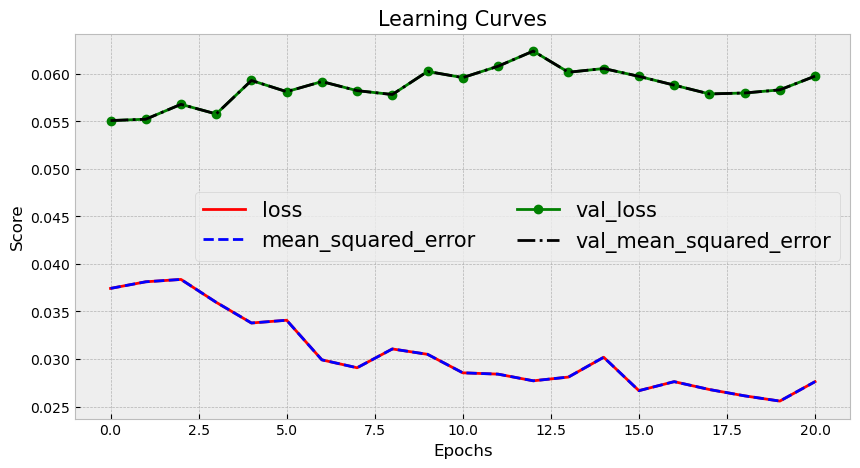

In [34]:
key_names = list(cars.history.keys())
colors = ['-r','--b','-og','-.k']

plt.figure(figsize=(10,5))
for i in range(len(key_names)):
    plt.plot(cars.history[key_names[i]], colors[i], label=key_names[i])
plt.legend(fontsize=15,ncol=2)
plt.title('Learning Curves', size=15);
plt.xlabel('Epochs');
plt.ylabel('Score');

In [35]:
#Function to compute Intersection over union.
def IOU(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    w_intersection = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_intersection = min(y1 + h1, y2 + h2) - max(y1, y2)

    if w_intersection <= 0 or h_intersection <= 0: 
        return 0

    Intersection = w_intersection * h_intersection
    Union = w1 * h1 + w2 * h2 - Intersection
    return Intersection / Union

1/1 [==============================] - 0s 31ms/step


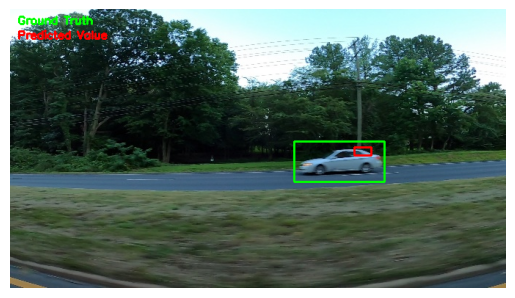

IOU for imagevid_4_9820.jpg:  0.6423905993091277
1/1 [==============================] - 0s 25ms/step


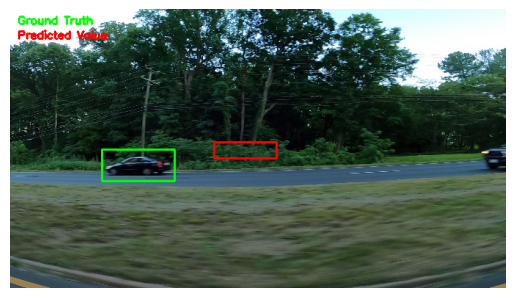

IOU for imagevid_4_9740.jpg:  0.12191064215939218
1/1 [==============================] - 0s 32ms/step


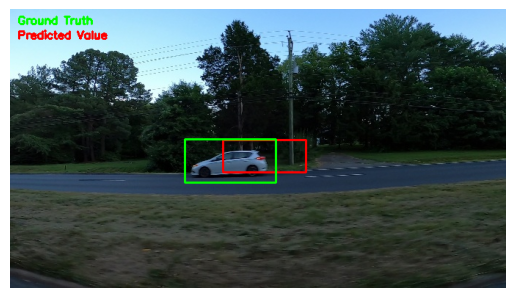

IOU for imagevid_4_10040.jpg:  0.6487678877806897


In [49]:
images = ['vid_4_9820.jpg', 'vid_4_9740.jpg', 'vid_4_10040.jpg']
indexes = []
i = 1

for image in images:
    filename='car_detection_dataset/training_images/'+image
    img = np.array(Image.open(filename))
    (h,w,c) = img.shape
    img = np.array(img)
    index = (bbox.index[bbox['image']==image][0])
    predicted_bbox = model.predict(np.expand_dims(img, axis=0))
    ground_truth = t_train[index]*(w,h,w,h)
    ground_truth = ground_truth.astype(int)

    predicted_bbox = predicted_bbox*(w,h,w,h)
    predicted_bbox = predicted_bbox.astype(int)
    
    cv2.putText(img, f"Ground Truth", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    cv2.putText(img, f"Predicted Value", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    cv2.rectangle(img, (predicted_bbox[0][0],  predicted_bbox[0][1]), 
              ( predicted_bbox[0][2],  predicted_bbox[0][3]), 
              (255, 0, 0), 2);
    
    cv2.rectangle(img, (ground_truth[0],  ground_truth[1]), 
              (ground_truth[2],  ground_truth[3]), 
              (0, 255, 0), 2);

    # Display the image on the corresponding subplot
    plt.imshow(img)
    plt.axis('off')
    
    plt.show()
    
    
    i = i+1

    # Show the plot
    # plt.show()

    iou = IOU(ground_truth, predicted_bbox[0])
    print('IOU for image' +image+': ', iou)

### 3. Adding the case when there are no cars in the image.

In [50]:
#Appending samples with [0,0,0,0] in which the cars are not present.
bbox = pd.read_csv('car_detection_dataset/train_bounding_boxes_nocars.csv')

data = []
N = len(bbox) # no. of training samples

# Create a numpy array with all images
for i in range(N): 
    filename='car_detection_dataset/training_images/'+bbox['image'][i]
    image = np.array(Image.open(filename))
    image_col = image.ravel()[:,np.newaxis]
    (h, w) = image.shape[:2]
    
    if i==0:
        X_train = image_col
    else:
        X_train = np.hstack((X_train, image_col))

# Training feature matrices
X_train = X_train.T

# Training labels
t_train = bbox.drop('image', axis=1).round().to_numpy().astype(int)

t_train = t_train.astype(float)

t_train[:, [0, 2]] /= w
t_train[:, [1, 3]] /= h

X_train.shape, t_train.shape

#Reshaping data
for i in range(578):
    img = X_train[i,:].reshape(380,676,3)
    img = np.array(img)
    data.append(img)

training_nocars = np.array(data)

X_train_nocars, X_val_nocars, t_train_nocars, t_val_nocars = train_test_split(training_nocars, t_train, shuffle = True, test_size=0.3, random_state=2)

In [54]:
base_model = keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    input_tensor=Input(shape=(380, 676, 3))
)

base_model.trainable = False


model_nocars = keras.models.Sequential([
    base_model,
    keras.layers.Flatten(), 
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(4, activation='sigmoid') #without normalization
])


#Learnign rate =0.01 - Gradient is not converging, my guess is its bouncing across the minima

loss = keras.losses.MeanSquaredError(name="mean_squared_error"
)

optimizer = keras.optimizers.Adam(
    learning_rate=0.001,
    name="adam")

model_nocars.compile(optimizer= optimizer, loss=loss, metrics=keras.metrics.MeanSquaredError(name="mean_squared_error"))

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,
                                                  monitor='val_loss', restore_best_weights=True)


In [55]:
nocars = model_nocars.fit(X_train_nocars,t_train_nocars, epochs = 300,batch_size = 10, validation_data=(X_val_nocars, t_val_nocars), callbacks=[early_stopping_cb])

Epoch 1/300
41/41 [==============================] - 4s 63ms/step - loss: 0.1155 - mean_squared_error: 0.1155 - val_loss: 0.2094 - val_mean_squared_error: 0.2094
Epoch 2/300
41/41 [==============================] - 2s 53ms/step - loss: 0.0805 - mean_squared_error: 0.0805 - val_loss: 0.0954 - val_mean_squared_error: 0.0954
Epoch 3/300
41/41 [==============================] - 2s 53ms/step - loss: 0.0775 - mean_squared_error: 0.0775 - val_loss: 0.0720 - val_mean_squared_error: 0.0720
Epoch 4/300
41/41 [==============================] - 2s 53ms/step - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.0639 - val_mean_squared_error: 0.0639
Epoch 5/300
41/41 [==============================] - 2s 53ms/step - loss: 0.0608 - mean_squared_error: 0.0608 - val_loss: 0.0609 - val_mean_squared_error: 0.0609
Epoch 6/300
41/41 [==============================] - 2s 52ms/step - loss: 0.0583 - mean_squared_error: 0.0583 - val_loss: 0.0616 - val_mean_squared_error: 0.0616
Epoch 7/300
41/41 [=========

1/1 [==============================] - 0s 174ms/step


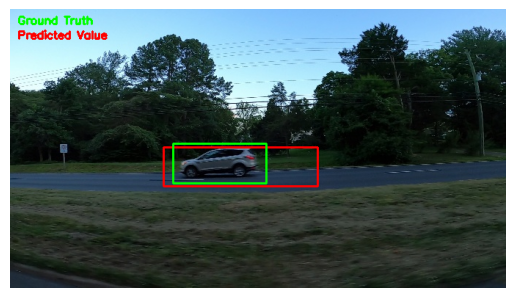

IOU for imagevid_4_9980.jpg:  0.7882091818854406
1/1 [==============================] - 0s 30ms/step


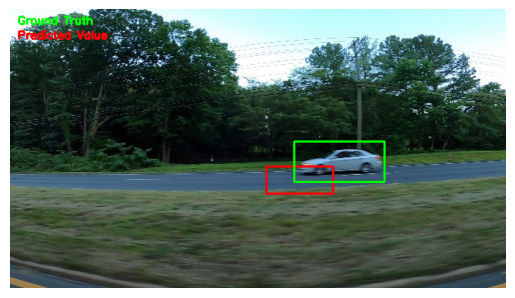

IOU for imagevid_4_9820.jpg:  0.5405249919725998
1/1 [==============================] - 0s 29ms/step


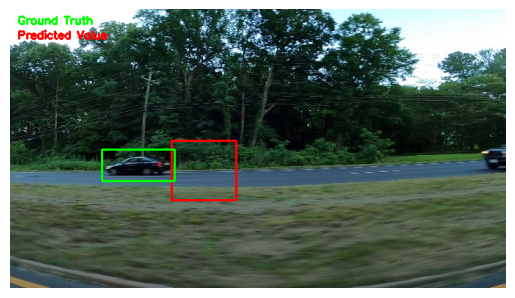

IOU for imagevid_4_9740.jpg:  0.29504447268106737
1/1 [==============================] - 0s 25ms/step


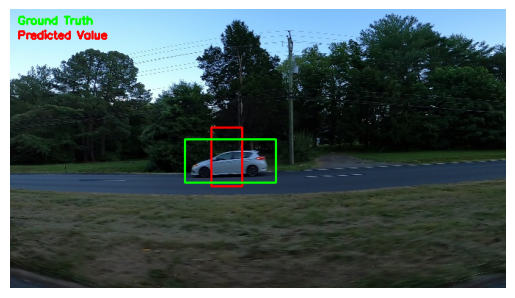

IOU for imagevid_4_10040.jpg:  0.7857395455751038


In [56]:
#Printing IOU for Region of Interest

images = ['vid_4_9980.jpg','vid_4_9820.jpg', 'vid_4_9740.jpg', 'vid_4_10040.jpg']
indexes = []
i = 1

for image in images:
    filename='car_detection_dataset/training_images/'+image
    img = np.array(Image.open(filename))
    (h,w,c) = img.shape
    img = np.array(img)
    index = (bbox.index[bbox['image']==image][0])
    predicted_bbox = model_nocars.predict(np.expand_dims(img, axis=0))
    ground_truth = t_train[index]*(w,h,w,h)
    ground_truth = ground_truth.astype(int)

    predicted_bbox = predicted_bbox*(w,h,w,h)
    predicted_bbox = predicted_bbox.astype(int)
    
    cv2.putText(img, f"Ground Truth", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    cv2.putText(img, f"Predicted Value", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    cv2.rectangle(img, (predicted_bbox[0][0],  predicted_bbox[0][1]), 
              ( predicted_bbox[0][2],  predicted_bbox[0][3]), 
              (255, 0, 0), 2);
    
    cv2.rectangle(img, (ground_truth[0],  ground_truth[1]), 
              (ground_truth[2],  ground_truth[3]), 
              (0, 255, 0), 2);

    # Display the image on the corresponding subplot
    plt.imshow(img)
    plt.axis('off')
    # plt.label()
    
    
    plt.show()
    
    
    i = i+1

    # Show the plot
    # plt.show()

    iou = IOU(ground_truth, predicted_bbox[0])
    print('IOU for image' +image+': ', iou)